In [1]:
# import data
import pandas as pd
import numpy as np
import csv
from sklearn import datasets, neighbors
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1234)
#from google.colab import files
##

# import Search Trends dataset (simply as std)
url_std = 'https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv'
#(98946,61) 
df_std = pd.read_csv(url_std, index_col=0, parse_dates=[0])

# import COVID hospitalization cases dataset (simply as chcd)
url_chcd = 'https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv'
df_chcd = pd.read_csv(url_chcd, index_col=0, parse_dates=[0])

In [2]:
## normalize
US_Region_case = [["US-AK","8477"],
                  ["US-DC","15264"],
                  ["US-DE","20534"],
                  ["US-HI","12351"],
                  ["US-ID","41386"],
                  ["US-ME","5300"],
                  ["US-MT","12538"],
                  ["US-ND","20986"],
                  ["US-NE","44578"],
                  ["US-NH","8208"],
                  ["US-NM","28985"],
                  ["US-RI","24424"],
                  ["US-SD","21738"],
                  ["US-VT","1745"],
                  ["US-WV","15512"],
                  ["US-WY","5754"]]
US_Total_case = 7231976
for row in US_Region_case: 
    row[1]=(int(row[1])/US_Total_case)

# reset region index
df_std.reset_index(level=0, inplace=True)
# extract regions into a list
regions = df_std.open_covid_region_code.unique()
copy = df_std.copy()

# extract symptoms into a list
symptoms = copy.drop(copy.iloc[:, [0,1,2,3,4,5,6,7]], axis = 1) # drop first few columns that are not needed.
symptoms = symptoms.columns.tolist()

# processing
for region in regions:
  index = (df_std['open_covid_region_code'] == region)
  for symptom in symptoms:
      for row in US_Region_case:
          if row[0] == region:
              df_std.loc[index, symptom]=df_std.loc[index, symptom]/df_std.loc[index, 'symptom:Abdominal obesity':'symptom:pancreatitis'].sum().sum()*row[1]*10000

df_std.to_csv('df_std_normalized.csv') 
    

In [3]:
# clean
nullRate = 0.8
cleaned_std = df_std.loc[:, df_std.isnull().mean() <= nullRate] 
print(cleaned_std)

# clean chcd by taking only hospitalized_new，removing the row with empty hospitalized_new
cleaned_chcd = df_chcd[['date', 'hospitalized_new']]
cleaned_chcd = cleaned_chcd.dropna(axis=0, subset=['hospitalized_new'])

# convert daily data to weekly
cleaned_chcd['date'] = cleaned_chcd ['date'].astype('datetime64[ns]')
cleaned_chcd = cleaned_chcd.groupby("open_covid_region_code").resample('W-MON', label='right', closed = 'right', on='date').sum().reset_index()

cleaned_chcd_us = cleaned_chcd.loc[3472:5278,:].reset_index()
cleaned_chcd_us = cleaned_chcd_us[['open_covid_region_code','date','hospitalized_new']]

    open_covid_region_code  ... symptom:Viral pneumonia
0                    US-AK  ...                     NaN
1                    US-AK  ...                     NaN
2                    US-AK  ...                     NaN
3                    US-AK  ...                     NaN
4                    US-AK  ...                0.161941
..                     ...  ...                     ...
635                  US-WY  ...                     NaN
636                  US-WY  ...                     NaN
637                  US-WY  ...                     NaN
638                  US-WY  ...                     NaN
639                  US-WY  ...                0.068401

[640 rows x 108 columns]


In [4]:
# saved to the foler on the left, click refresh and download to see the whole dataset.
cleaned_chcd.to_csv('hospitalized_new_cleaned.csv') 
cleaned_chcd_us.to_csv('hospitalized_new_cleaned_us.csv')

In [5]:
# change date format and then merge them
cleaned_chcd["date"] = pd.to_datetime(cleaned_chcd["date"], format="%Y-%m-%d")

cleaned_std["date"] = pd.to_datetime(cleaned_std["date"], format="%Y-%m-%d")

merged = pd.merge(cleaned_chcd, cleaned_std, how='right', on=['date','open_covid_region_code'])
merged.fillna(0, inplace=True)

#from google.colab import files
merged.to_csv('merged_data.csv') 

In [6]:

'''
Section 3: using KNN and decsion tree to predict the hospitaliztion cases given the sesarch trends data.(regression)

    sub task1: Split the data into train and validation sets using two strategies (base on region and base on time) 80% 
                in training and 20% in validation.(5-fold)
    sub task2: Compare the regression performence of KNNs and decision trees for each of the train-validation split stategies.
                (report the validation error on both cases)
    optioal task: explore other prediciton strategies.
    
In summary: 
    we need to do 4 seprate operation namely: 
        1, tree with region spilt 
        2, tree with time split 
        3, KNN with regino split 
        4, KNN with tike split
    steps to finish the mission: 
        1, split the data in region and time split form  and save them as dataRegion and dataTime respectively
        (https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/ModelSelection.ipynb)
        2, constract a tree structure into a function: TreeStruct()
        3, construct a KNN structure into a function: KNNStruct()
        4, apply data into the tree structure and perform 5-fold validation test
        5, apply data into the KNN structure and perform 5-fold validation test
'''


'\nSection 3: using KNN and decsion tree to predict the hospitaliztion cases given the sesarch trends data.(regression)\n\n    sub task1: Split the data into train and validation sets using two strategies (base on region and base on time) 80% \n                in training and 20% in validation.(5-fold)\n    sub task2: Compare the regression performence of KNNs and decision trees for each of the train-validation split stategies.\n                (report the validation error on both cases)\n    optioal task: explore other prediciton strategies.\n    \nIn summary: \n    we need to do 4 seprate operation namely: \n        1, tree with region spilt \n        2, tree with time split \n        3, KNN with regino split \n        4, KNN with tike split\n    steps to finish the mission: \n        1, split the data in region and time split form  and save them as dataRegion and dataTime respectively\n        (https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/ModelSele

In [7]:

def corr_calculation (data, corr): 
    get_symptom_list = data.copy();  
    get_symptom_list = get_symptom_list.drop(get_symptom_list.iloc[:, [0,1,2,3,4,5,6,7]], axis = 1) 
    symptom_list = get_symptom_list.columns.tolist()  
    num_present = 0  
    num_drop = 0  
    for symptom in symptom_list:    
        merged = data.copy()    
        # delete the row that number is 0    
        merged = merged.loc[~(merged[symptom] == 0)]   
        data1 = merged[symptom]    
        data2 = merged['hospitalized_new']    
    # 102 symptom before any drop. 48 symptom if corr > 0.3    
        if ( merged[symptom].corr(merged['hospitalized_new']) > corr):     
           # print(symptom)      
           # print(merged[symptom].corr(merged['hospitalized_new']))      
            num_present = num_present + 1    
        else:      
            data = data.drop(symptom, 1)      
            num_drop = num_drop + 1  
    print (num_present)  
    print (num_drop)  
    print (data.shape)  
    data.to_csv('merged_corr_data.csv') 

In [8]:

'''
Step #3: define MSE function
def loss(y,yh):
    np.mean((y-yh)**2)
'''
loss = lambda y, yh: np.mean((y-yh)**2)
'''    
tsting = loss(1,3)
print(tsting)
'''

'    \ntsting = loss(1,3)\nprint(tsting)\n'

In [9]:
import csv
from sklearn import datasets, neighbors
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings('ignore')
np.random.seed(1234)

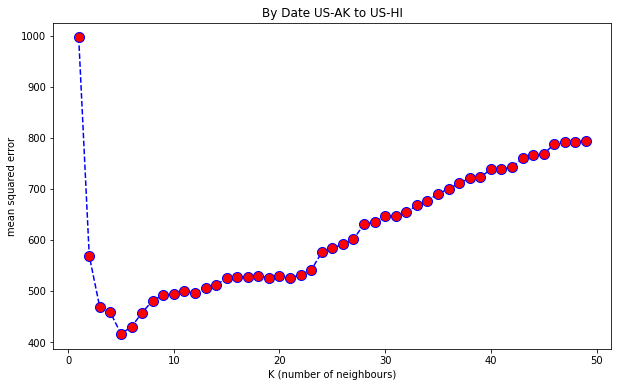

Minimum error:  415.62725 at K = 4


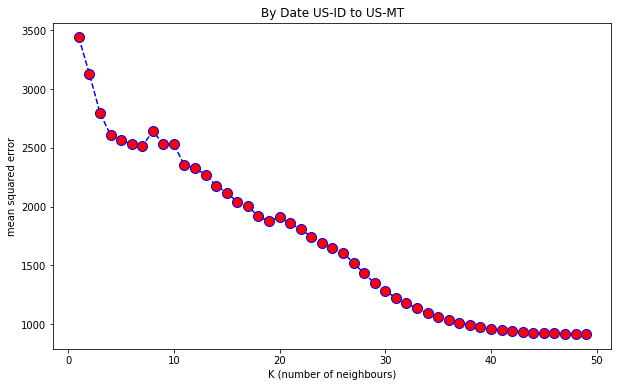

Minimum error:  916.2654657781482 at K = 48


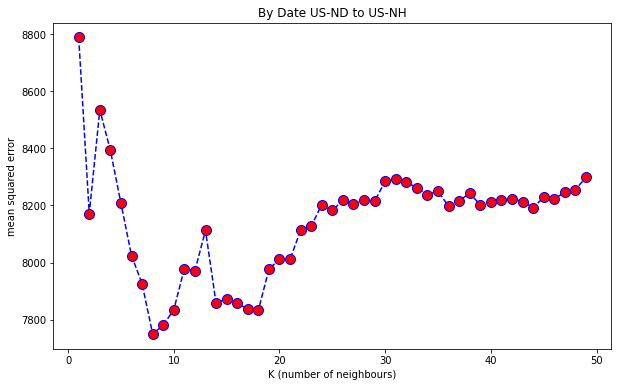

Minimum error:  7750.30625 at K = 7


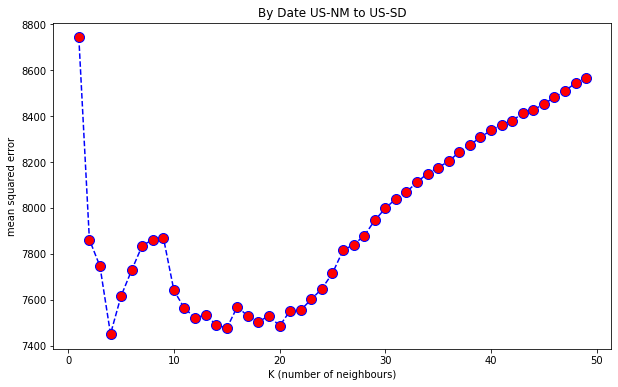

Minimum error:  7450.566145833333 at K = 3


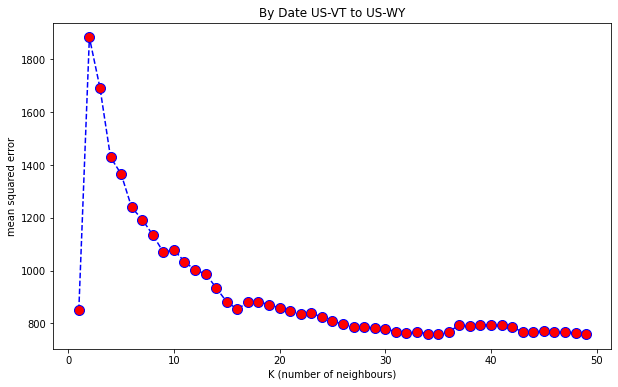

Minimum error:  759.7156879078159 at K = 48


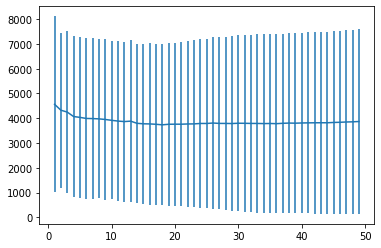

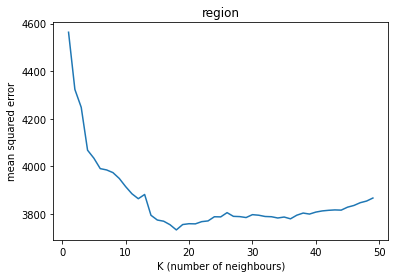

Minimun mean error:  3733.2228137860097 at K = 17


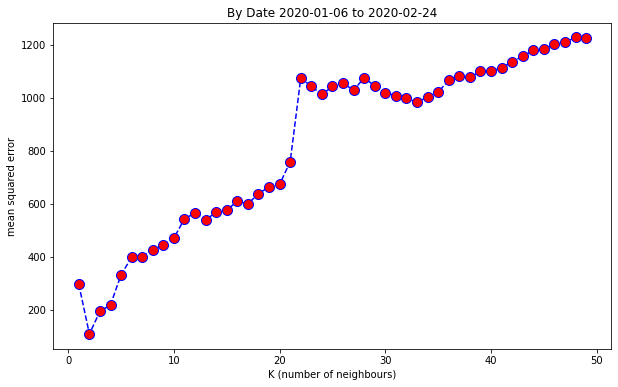

Minimum error:  108.744140625 at K = 1


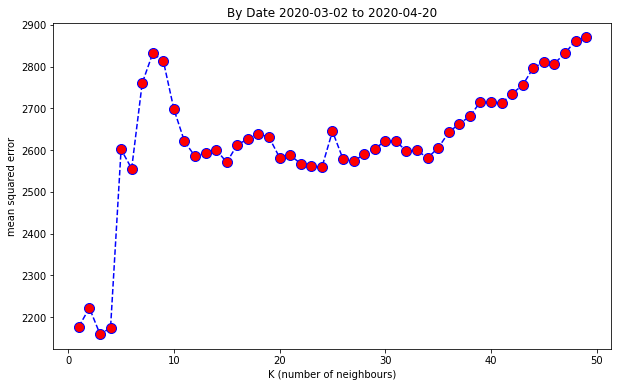

Minimum error:  2159.421006944445 at K = 2


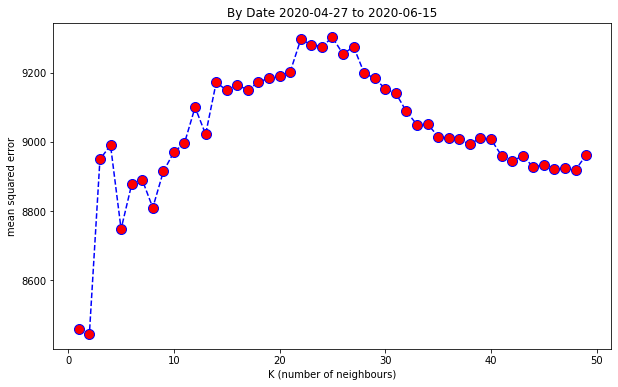

Minimum error:  8444.083984375 at K = 1


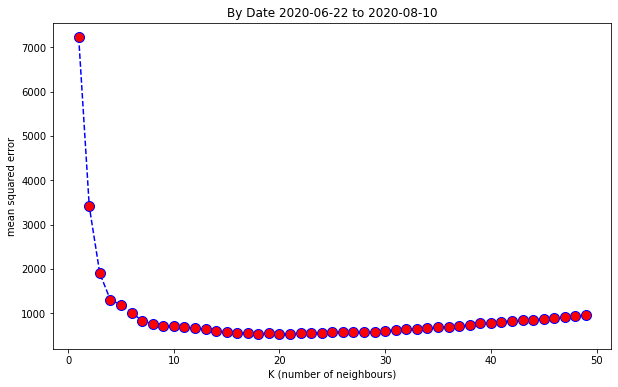

Minimum error:  530.4408593750001 at K = 19


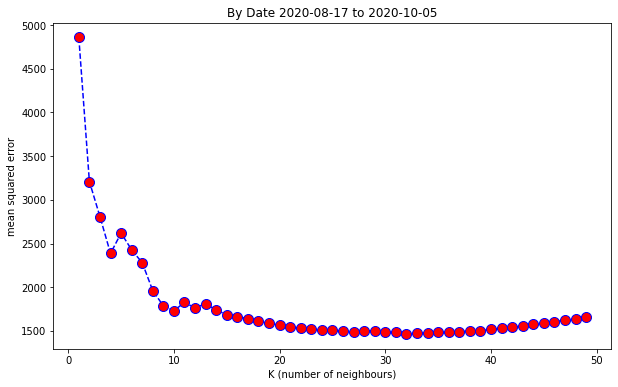

Minimum error:  1465.085678100586 at K = 31


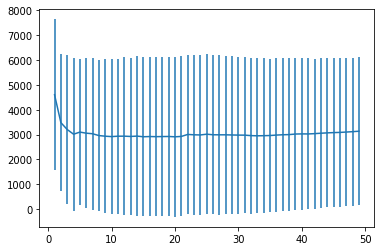

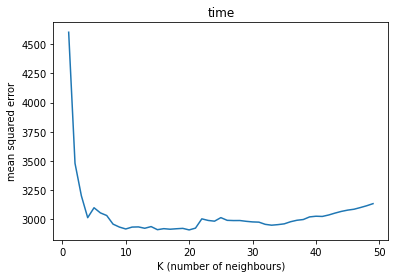

Minimun mean error:  2908.6548437499996 at K = 19


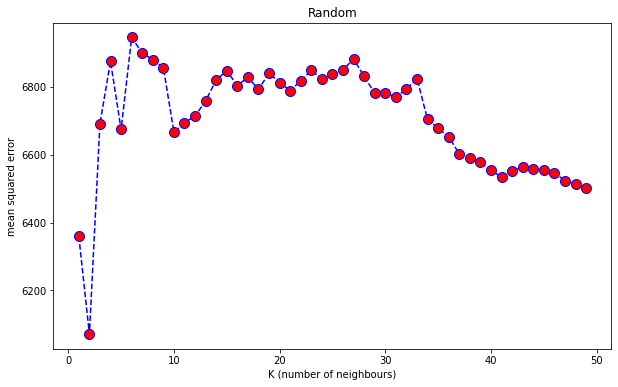

Minimum error:  6071.316 at K = 1


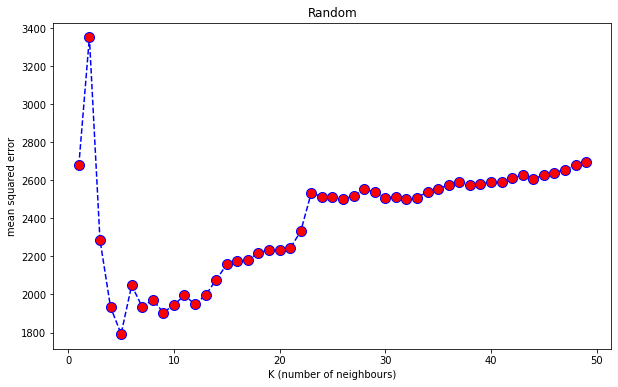

Minimum error:  1792.4982400000001 at K = 4


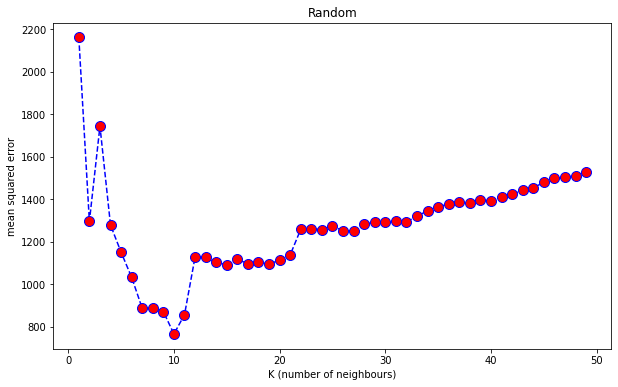

Minimum error:  766.4254400000001 at K = 9


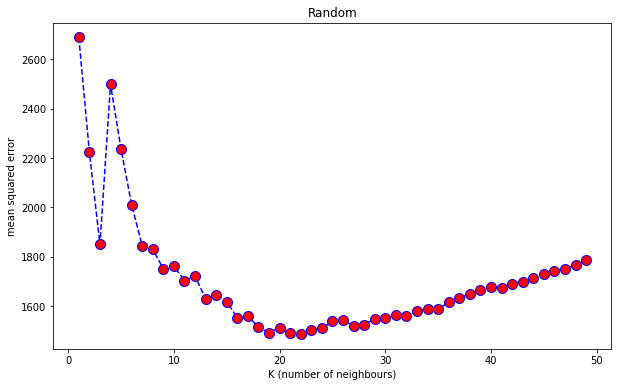

Minimum error:  1486.9686942148765 at K = 21


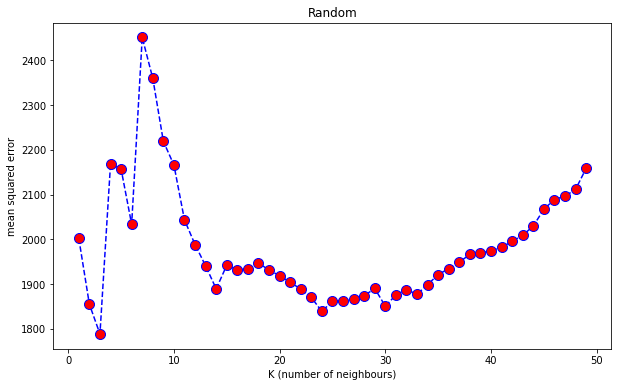

Minimum error:  1788.7428315412183 at K = 2


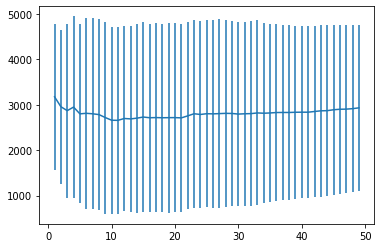

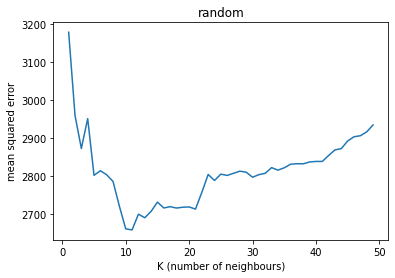

Minimun mean error:  2658.535382031458 at K = 10


2658.535382031458

In [10]:
# complete_df will be the margined data 
def knn_Regressor(complete_df, split_type, K_list, num_fold):
  #print("Split Type: " + str(split_type))
  if split_type == 'region':
    splitted = complete_df.open_covid_region_code.unique()
    column = 'open_covid_region_code'
  elif split_type == 'random':
    splitted = np.random.permutation(624)
    column = 'index'
  else:
    splitted = complete_df.date.unique()
    column = 'date'

  splitted = np.array_split(np.array(splitted),num_fold)

  error_cross_valid = np.zeros((len(K_list) , num_fold))
  for s, test_list in enumerate(splitted):

    train = complete_df[~complete_df[column].isin(test_list)]
    test = complete_df[complete_df[column].isin(test_list)]

    X_train = train.drop(train.iloc[:, [0,1,2,4,5,6,7]], axis = 1)
    X_train = X_train.drop(['hospitalized_new'], axis = 1)
    
    X_test = test.drop(test.iloc[:, [0,1,2,4,5,6,7]], axis = 1)
    X_test = X_test.drop(['hospitalized_new'], axis = 1)

    Y_train = train['hospitalized_new']
    Y_test = test['hospitalized_new']


    error_rate = []
    for k, i in enumerate(K_list):
        knn = neighbors.KNeighborsRegressor(n_neighbors=i)
        knn.fit(X_train,Y_train)
        error_rate.append(loss(Y_test, knn.predict(X_test)))
        error_cross_valid[k,s]=loss(Y_test, knn.predict(X_test))

    plt.figure(figsize=(10,6))
    plt.plot(K_list,error_rate,color='blue', linestyle='dashed', 
        marker='o',markerfacecolor='red', markersize=10)

    if split_type == 'region':
        plt.title('By Region')
    if split_type == 'random':
        plt.title('Random')
    else:
        plt.title('By Date ' + str(test_list[0]) +  ' to ' + str(test_list[-1])) 
    plt.xlabel('K (number of neighbours)')
    plt.ylabel('mean squared error')
    plt.show()
    print("Minimum error: ",min(error_rate),"at K =",error_rate.index(min(error_rate)))

  plt.errorbar(K_list, np.mean(error_cross_valid, axis=1), np.std(error_cross_valid, axis=1), label='validation')
  plt.show()
  plt.plot(K_list, np.mean(error_cross_valid, axis=1), label='mean value')
  error_cross_valid_mean = np.mean(error_cross_valid, axis=1).tolist()

  plt.xlabel('K (number of neighbours)')
  plt.ylabel('mean squared error')
  plt.title(split_type)
  plt.show()
  print("Minimun mean error: ", min(np.mean(error_cross_valid, axis=1)), "at K =", error_cross_valid_mean.index(min(np.mean(error_cross_valid, axis=1))))
  return(min(np.mean(error_cross_valid, axis=1)))

merged = pd.read_csv("merged_data.csv")
merged = merged.drop(merged.iloc[:,[0]], axis =1 )
merged_indexed = merged.reset_index()

knn_Regressor(merged_indexed, 'region', range(1,50), 5) 
knn_Regressor(merged_indexed, 'time', range(1,50), 5) 
knn_Regressor(merged_indexed, 'random', range(1,50), 5)

Split Type: region
[array(['US-AK', 'US-DC', 'US-DE', 'US-HI'], dtype=object), array(['US-ID', 'US-ME', 'US-MT'], dtype=object), array(['US-ND', 'US-NE', 'US-NH'], dtype=object), array(['US-NM', 'US-RI', 'US-SD'], dtype=object), array(['US-VT', 'US-WV', 'US-WY'], dtype=object)]


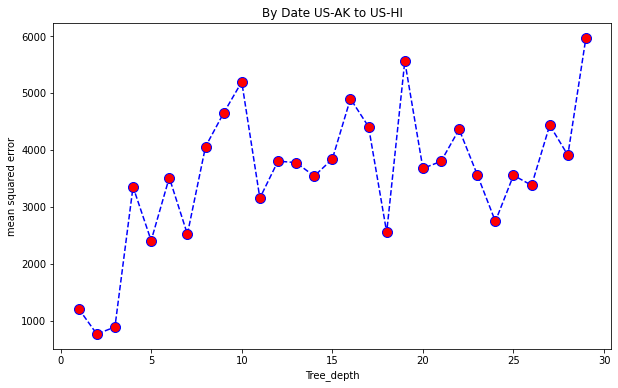

Minimum error:  762.934840028261 at depth = 1


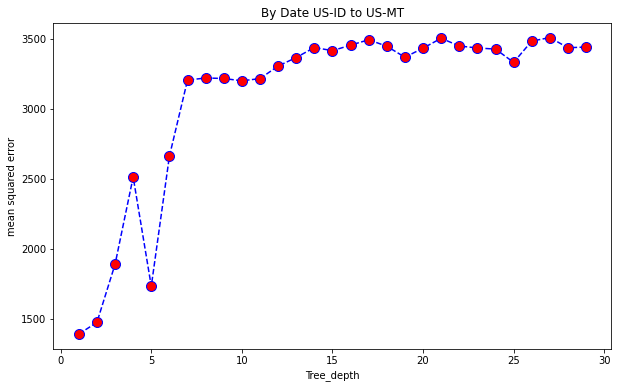

Minimum error:  1390.6083248536495 at depth = 0


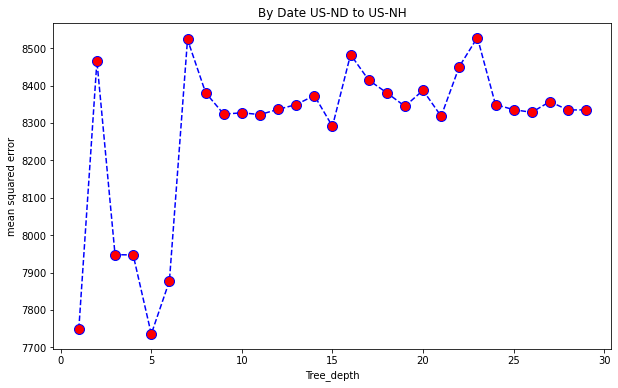

Minimum error:  7735.700495331979 at depth = 4


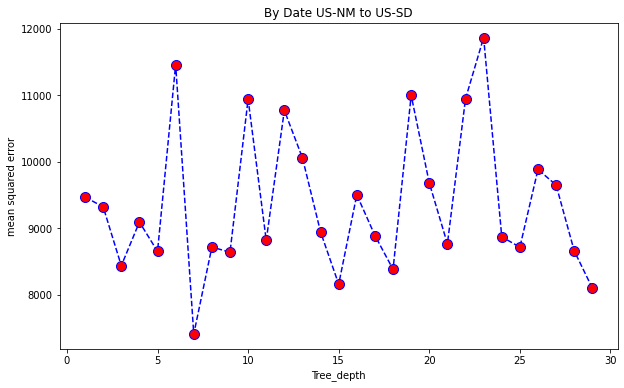

Minimum error:  7411.237834782525 at depth = 6


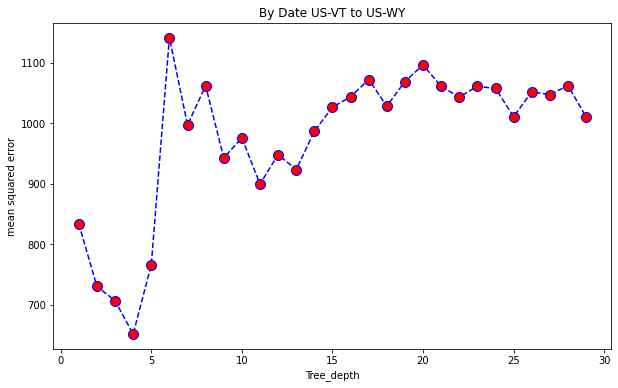

Minimum error:  651.8466294905097 at depth = 3


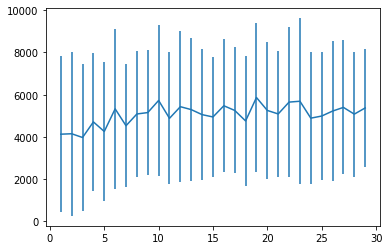

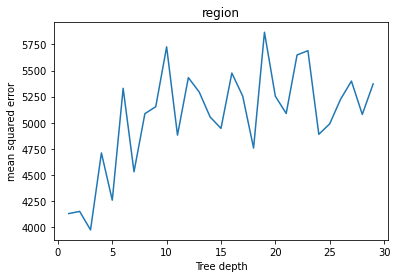

Minimun mean error:  3973.5542741895056 at depth = 2
Split Type: time
[array(['2020-01-06', '2020-01-13', '2020-01-20', '2020-01-27',
       '2020-02-03', '2020-02-10', '2020-02-17', '2020-02-24'],
      dtype=object), array(['2020-03-02', '2020-03-09', '2020-03-16', '2020-03-23',
       '2020-03-30', '2020-04-06', '2020-04-13', '2020-04-20'],
      dtype=object), array(['2020-04-27', '2020-05-04', '2020-05-11', '2020-05-18',
       '2020-05-25', '2020-06-01', '2020-06-08', '2020-06-15'],
      dtype=object), array(['2020-06-22', '2020-06-29', '2020-07-06', '2020-07-13',
       '2020-07-20', '2020-07-27', '2020-08-03', '2020-08-10'],
      dtype=object), array(['2020-08-17', '2020-08-24', '2020-08-31', '2020-09-07',
       '2020-09-14', '2020-09-21', '2020-09-28', '2020-10-05'],
      dtype=object)]


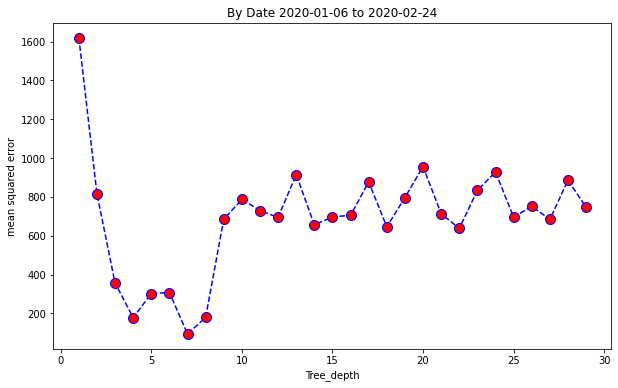

Minimum error:  93.08848572337065 at depth = 6


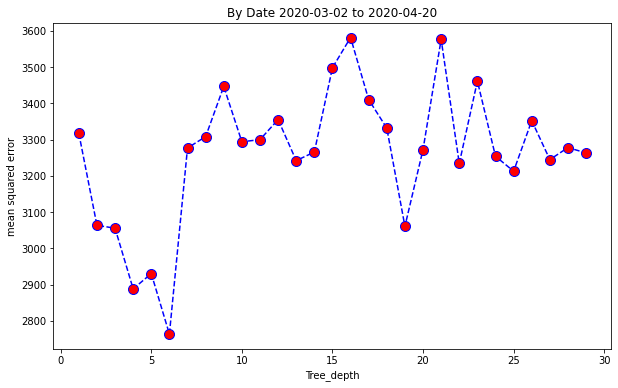

Minimum error:  2763.9439535530805 at depth = 5


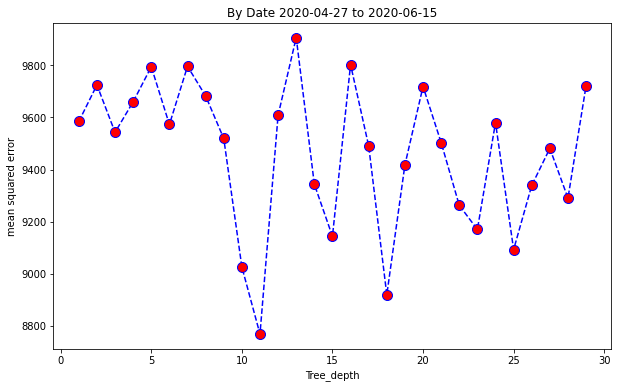

Minimum error:  8768.904250146701 at depth = 10


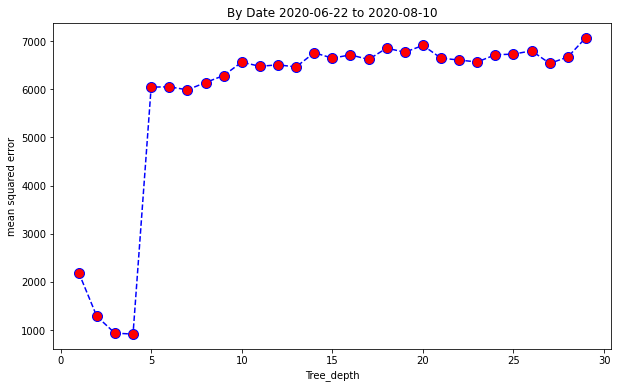

Minimum error:  919.9553441964277 at depth = 3


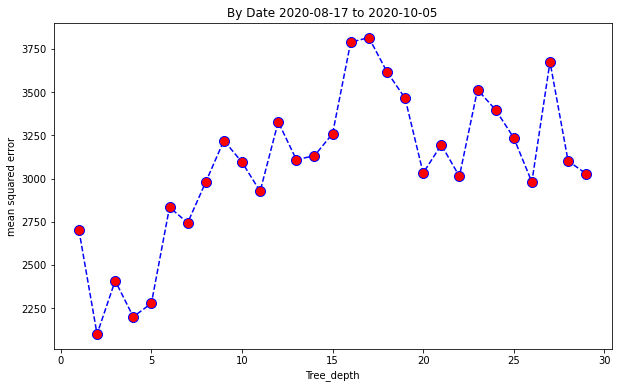

Minimum error:  2099.3714203864 at depth = 1


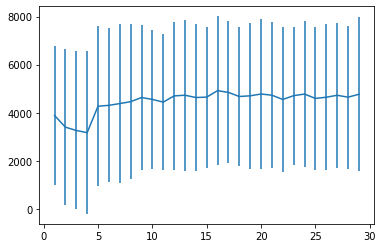

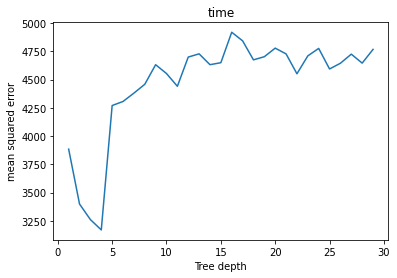

Minimun mean error:  3169.070234970544 at depth = 3
Split Type: random
[array([ 12, 614, 597, 572,  45, 240, 270, 568, 603, 499,  27, 294, 596,
        98, 530, 486, 394,  96, 263, 132,  81, 129, 472, 365, 213, 427,
        15, 459, 385, 560,  43, 318, 138, 421, 575, 296, 200, 151,  53,
       154, 334,   4, 224, 494, 458,  73, 521, 191,  72,  76, 419, 314,
       223, 489, 418, 123, 591, 470, 404, 433, 147, 412, 292, 522, 484,
       299, 502, 101,   6, 316, 557, 142, 349, 366, 452, 166, 583,  36,
       120, 606, 310, 466, 536, 442, 621, 348, 229,  97, 616, 347, 352,
        84, 351, 254, 164, 576, 141, 242, 117, 482, 283,  60,  32, 112,
       189, 496,  11, 357,  38,   5, 179, 180, 306, 219, 464, 378, 480,
       207, 308, 209, 105, 551, 463, 121, 133]), array([176, 169, 304, 325, 392, 533, 531, 598, 500,  64,  90, 562,  50,
       276, 303, 408,  51, 212, 371, 286,  91, 479, 150, 393, 238, 307,
        35, 454, 343, 599, 435, 477, 206, 230, 124, 157, 448, 104, 259,
       595, 329

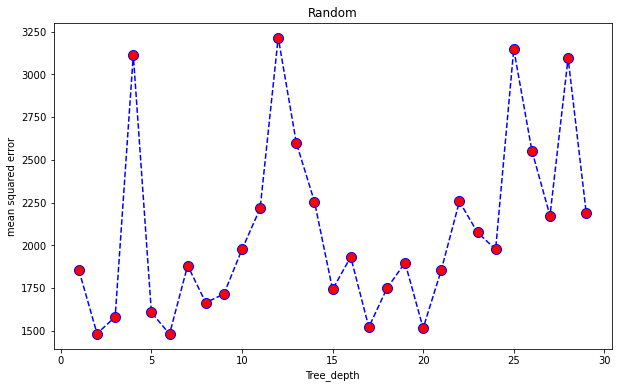

Minimum error:  1480.4367234554106 at depth = 5


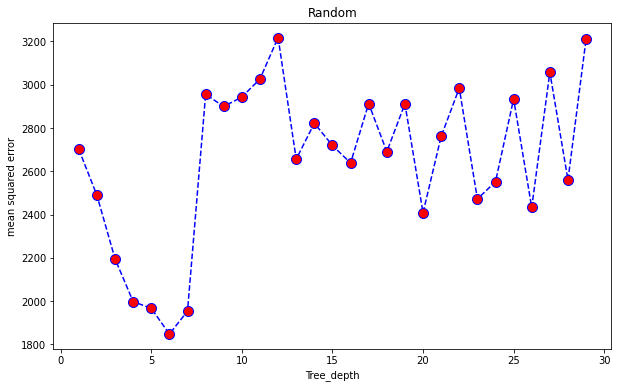

Minimum error:  1847.9393638330196 at depth = 5


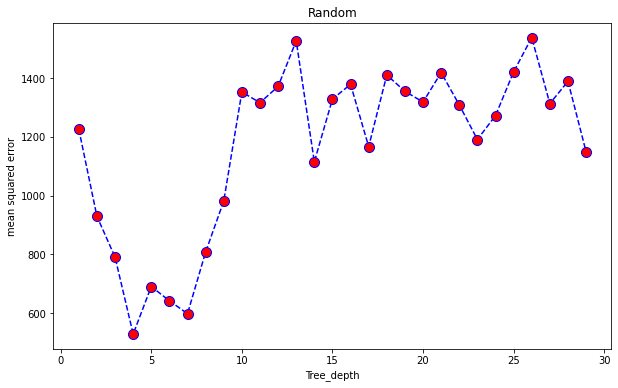

Minimum error:  528.636215591806 at depth = 3


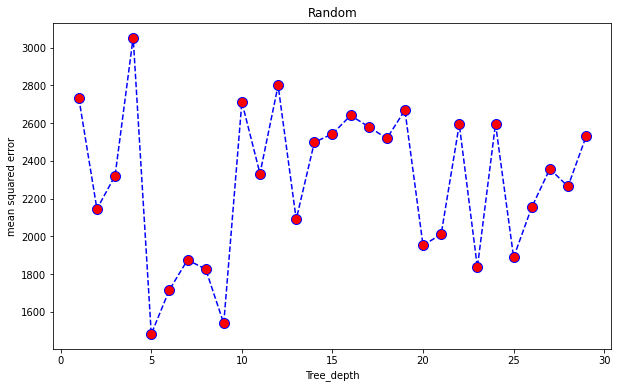

Minimum error:  1482.6028790033777 at depth = 4


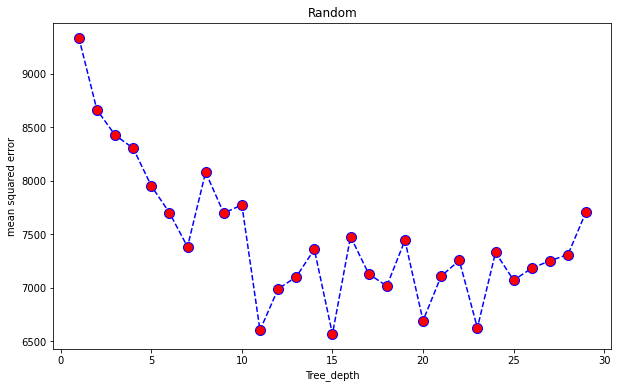

Minimum error:  6565.425749399721 at depth = 14


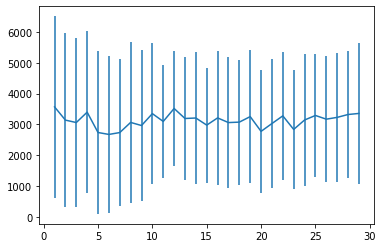

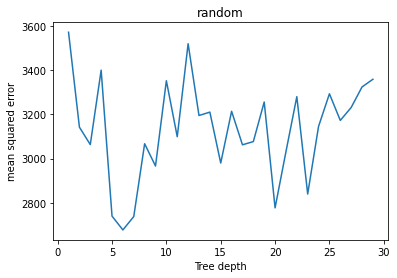

Minimun mean error:  2677.4725799165985 at depth = 5


In [11]:
from sklearn.tree import DecisionTreeRegressor
# complete_df will be the margined data 
def Tree_regressor(complete_df, split_type, tree_depth, num_fold):
    print("Split Type: " + str(split_type))
    if split_type == 'region':
        splitted = complete_df.open_covid_region_code.unique()
        column = 'open_covid_region_code'
    elif split_type == 'random':
        splitted = np.random.permutation(624)
        column = 'index'
    else:
        splitted = complete_df.date.unique()
        column = 'date'

    splitted = np.array_split(np.array(splitted),num_fold)
    print(splitted)
  
    error_cross_valid = np.zeros((len(tree_depth) , num_fold))
    for s, test_list in enumerate(splitted):

        train = complete_df[~complete_df[column].isin(test_list)]
        test = complete_df[complete_df[column].isin(test_list)]
        train = train.sample(frac=1)
        test = test.sample(frac=1)

        X_train = train.drop(train.iloc[:, [0,1,2,4,5,6,7]], axis = 1)
        X_train = X_train.drop(['hospitalized_new'], axis = 1)

        X_test = test.drop(test.iloc[:, [0,1,2,4,5,6,7]], axis = 1)
        X_test = X_test.drop(['hospitalized_new'], axis = 1)

        Y_train = train['hospitalized_new']
        Y_test = test['hospitalized_new']

        error_rate = []
        for k, i in enumerate(tree_depth):
            dt = DecisionTreeRegressor(max_depth = i)
            dt.fit(X_train,Y_train)
            error_rate.append(loss(Y_test, dt.predict(X_test)))
            error_cross_valid[k,s]=loss(Y_test, dt.predict(X_test))

        plt.figure(figsize=(10,6))
        plt.plot(tree_depth, error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
        # plt.legend()
        if split_type == 'region':
            plt.title('By Region')
        if split_type == 'random':
            plt.title('Random')
        else:
            plt.title('By Date ' + str(test_list[0]) +  ' to ' + str(test_list[-1])) 
        plt.xlabel('Tree_depth')
        plt.ylabel('mean squared error')
        plt.show()
        print("Minimum error: ",min(error_rate),"at depth =",error_rate.index(min(error_rate)))

    plt.errorbar(tree_depth, np.mean(error_cross_valid, axis=1), np.std(error_cross_valid, axis=1), label='validation')
    plt.show()
    plt.plot(tree_depth, np.mean(error_cross_valid, axis=1), label='mean value')
    error_cross_valid_mean = np.mean(error_cross_valid, axis=1).tolist()
    
    plt.xlabel('Tree depth')
    plt.ylabel('mean squared error')
    plt.title(split_type)
    plt.show()
    print("Minimun mean error: ", min(np.mean(error_cross_valid, axis=1)), "at depth =", error_cross_valid_mean.index(min(np.mean(error_cross_valid, axis=1))))

merged_indexed = merged.reset_index()
Tree_regressor(merged_indexed, 'region', range(1,30), 5)
Tree_regressor(merged_indexed, 'time', range(1,30), 5)
Tree_regressor(merged_indexed, 'random', range(1,30), 5)